# Text classification system that can automatically categorize customer complaints

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk, json
nltk.download('punkt')

import torch
from torch.utils.data import TensorDataset, DataLoader

import tensorflow as tf
import tensorflow_hub as hub

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load and EDA

In [126]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [127]:
with open('/content/drive/My Drive/code/Ticket/vocab.json', 'r') as f1:
    vocab = json.load(f1)
with open('/content/drive/My Drive/code/Ticket/text.json', 'r') as f2:
    text = json.load(f2)
labels = np.load('/content/drive/My Drive/code/Ticket/labels.npy')

vocab_size = len(vocab)
print(f'Vocab size: {vocab_size}')

Vocab size: 10146


In [128]:
vocab[:10]

['_PAD', '_UNK', 'the', '.', 'i', 'to', ',', 'and', 'a', 'my']

In [129]:
df = pd.DataFrame({"text": text, "labels": labels})
df.head()

,text,labels
0,"[i, called, because, i, have, been, receiving,...",2
1,"[this, call, took, place, at, around, noon, ,,...",2
2,"[i, am, a, victim, of, identity, theft, and, t...",2
3,"[conn, 's, calls, my, husband, 's, work, (, ),...",2
4,"[i, was, called, on, by, from, claiming, i, ha...",2


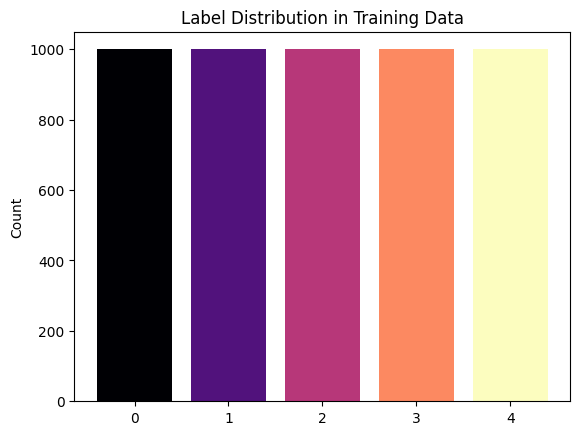

In [147]:
unique, counts = np.unique(labels, return_counts=True)
label_count = dict(zip(unique, counts))

counts_array = np.array(list(label_count.values()))
ranks = np.argsort(np.argsort(counts_array))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(label_count.keys(), label_count.values(), color=colors)
plt.ylabel("Count")
plt.title("Label Distribution in Training Data")
plt.show()

## Prepare Data for Prediction
#### Dictionaries to store the word to index mappings and vice versa

In [131]:
word_idx = {o:i for i,o in enumerate(vocab)}

#### Assign the index to the words based on created dictionary

In [132]:
texts = text.copy()

for i, sentence in enumerate(text):
    texts[i] = [word_idx[word] if word in word_idx else 0 for word in sentence]

#### Define a function that either shortens sentences or pads sentences with 0 to a fixed length

In [133]:
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

texts = pad_input(texts, 50)

#### Create TensorFlow Dataset

In [134]:
train_text, test_text, train_label, test_label = train_test_split(texts, labels, test_size=0.2, random_state=42, shuffle=True)

In [135]:
train_val_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_label))

train_ratio = 0.9
total_size = len(train_text)
train_size = int(train_ratio * total_size)

train_dataset = train_val_dataset.take(train_size)
val_dataset = train_val_dataset.skip(train_size)

train_dataset = train_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.squeeze(x), y)).batch(1).prefetch(tf.data.AUTOTUNE)

In [136]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_label))
test_dataset = test_dataset.shuffle(len(test_text)).batch(1)

## Data Prediction
#### Initialize embedding layer

In [137]:
embedding_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)

In [138]:
from tensorflow.keras.layers import Layer

# Wrap hub.KerasLayer inside a Custom Layer
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_layer):
        super(HubEmbeddingLayer, self).__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

#### Initialize Model

In [139]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=50),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(5, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [140]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [141]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.2948 - loss: 1.5325 - val_accuracy: 0.6350 - val_loss: 0.9359
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.7370 - loss: 0.7878 - val_accuracy: 0.7600 - val_loss: 0.7222
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8673 - loss: 0.4409 - val_accuracy: 0.8000 - val_loss: 0.6999
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9122 - loss: 0.3087 - val_accuracy: 0.7750 - val_loss: 0.8368
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.9297 - loss: 0.2402 - val_accuracy: 0.7700 - val_loss: 0.8477
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.9494 - loss: 0.1816 - val_accuracy: 0.8000 - val_loss: 0.7494
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9701 - loss: 0.1168 - val_accuracy: 0.7825 - val_loss: 0.8248
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.9744 - loss: 0.1059 - val_a

In [142]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 128)             │       1,298,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,045,265 (15.43 MB)

 Trainable params: 1,348,421 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,696,844 (10.29 MB)

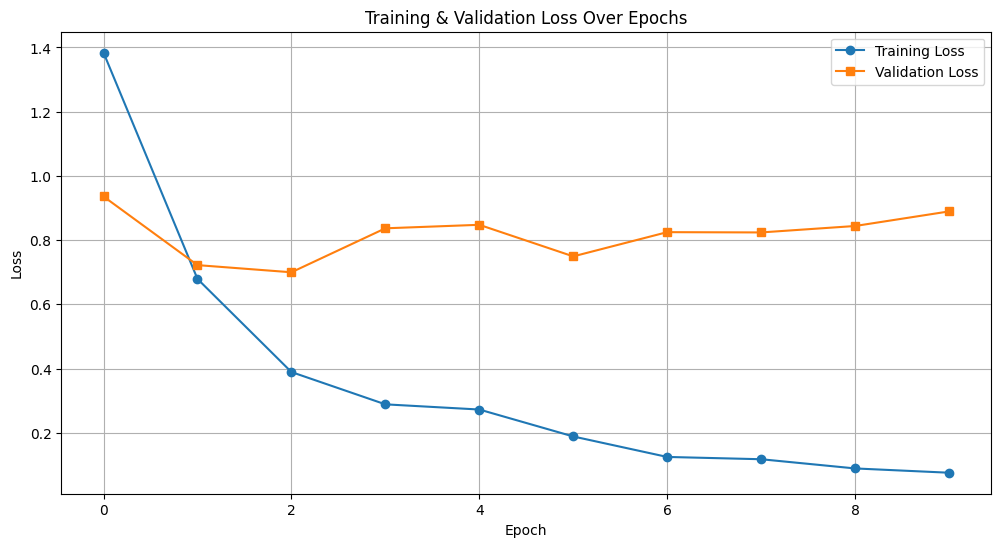

In [143]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Training & Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

#### Evaluation

In [144]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8049 - loss: 0.7598
Test Loss: 0.8135
Test Accuracy: 0.8020


In [145]:
x_test, y_true = zip(*[data for data in test_dataset]) # Extract from dataset
x_test = np.squeeze(x_test)
x_test = np.array(x_test)
y_true = np.array(y_true)

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Convert to class labels

print(classification_report(y_true, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       192
           1       0.73      0.74      0.73       190
           2       0.85      0.84      0.84       216
           3       0.82      0.80      0.81       192
           4       0.89      0.89      0.89       210

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



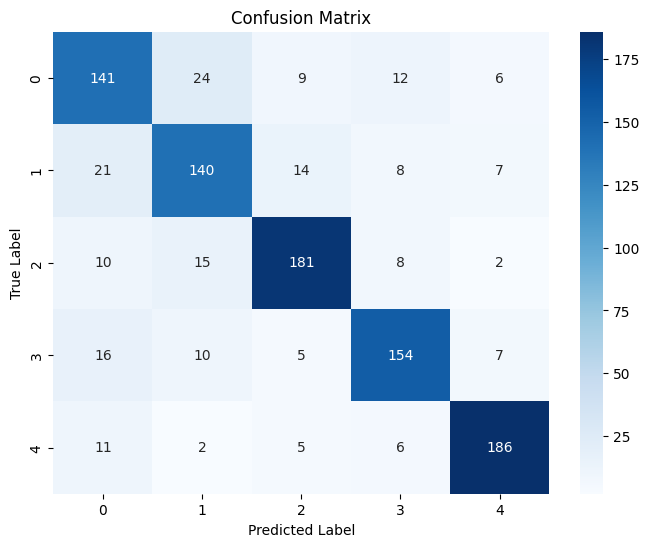

In [146]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()